In [ ]:
!pip install numpy==1.23.5 --quiet

import os
os.kill(os.getpid(), 9)

In [1]:
!pip install transformers datasets evaluate timm captum wandb --quiet

In [4]:
import os
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"

import random
import torch
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from io import BytesIO
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup
import timm
from torch.optim import AdamW
from tabulate import tabulate

# fix seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# config
config = {
    "dataset_name":     "cifar100",
    "num_labels":       100,
    "train_frac":       0.80,
    "val_frac":         0.10,
    "holdout_frac":     0.10,
    "batch_size_train": 128,
    "batch_size_val":   256,
    "max_epochs":       25,
    "patience":         5,
    "warmup_epochs":    3,
    "output_dir":       "./vit-cifar100-checkpoints",
    "sweep_variants": [
        {"name": "A", "lr": 5e-5, "weight_decay": 0.05},
        {"name": "B", "lr": 1e-4, "weight_decay": 0.02},
        {"name": "C", "lr": 3e-5, "weight_decay": 0.10},
    ],
}
os.makedirs(config["output_dir"], exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### helper functions

In [5]:
def print_heading(kind: str, number: int, description: str):
    label = f"{kind} {number}"
    print(f"\n\033[1m{label}\033[0m. {description}")

### Loading in CIFAR-100

In [8]:
import os
import warnings
import torch
import torch.nn as nn
import timm
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from datasets import load_dataset, logging as hf_logging, disable_progress_bar
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from io import BytesIO
from math import ceil

# remoce & Silence: HF and deprecation warnings
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"
hf_logging.set_verbosity_error()
disable_progress_bar()
warnings.filterwarnings("ignore", category=FutureWarning)

# load & split the HuggingFace dataset
ds = load_dataset(config["dataset_name"])["train"]
split1   = ds.train_test_split(test_size=config["holdout_frac"], seed=seed)
tmp, hold = split1["train"], split1["test"]
val_prop = config["val_frac"] / (config["train_frac"] + config["val_frac"])
split2   = tmp.train_test_split(test_size=val_prop, seed=seed)
train_ds, val_ds, holdout_ds = split2["train"], split2["test"], hold

# define transforms & preprocess helper
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

def preprocess_batch(batch, train: bool):
    imgs, labels = batch["img"], batch["fine_label"]
    pxs, lbs = [], []
    for img, lbl in zip(imgs, labels):
        if isinstance(img, list):
            img = img[0]
        if not isinstance(img, Image.Image):
            buf = img if isinstance(img, (bytes, bytearray)) else img.tobytes()
            img = Image.open(BytesIO(buf)) if isinstance(buf, (bytes, bytearray)) else Image.fromarray(img)
        pil = img.convert("RGB")
        transform = train_tf if train else eval_tf
        pxs.append(transform(pil))
        lbs.append(lbl)
    return {"pixel_values": pxs, "labels": lbs}

batch_size = 1000

# preprocess splits
train_ds   = train_ds.map(
    lambda b: preprocess_batch(b, train=True),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)
val_ds     = val_ds.map(
    lambda b: preprocess_batch(b, train=False),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)
holdout_ds = holdout_ds.map(
    lambda b: preprocess_batch(b, train=False),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)

# build DataLoaders
for ds_ in (train_ds, val_ds, holdout_ds):
    ds_.set_format(type="torch", columns=["pixel_values", "labels"])

num_workers = max(1, os.cpu_count() - 1)
train_loader   = DataLoader(train_ds,   batch_size=config["batch_size_train"],
                            shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader     = DataLoader(val_ds,     batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=num_workers, pin_memory=True)
holdout_loader = DataLoader(holdout_ds, batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=num_workers, pin_memory=True)

# summary print-out
print(f"Loaded data ⇒ Train: {len(train_ds)}, Val: {len(val_ds)}, Holdout: {len(holdout_ds)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded data ⇒ Train: 40000, Val: 5000, Holdout: 5000


## 1 - Fine-tuning

In [12]:
import os
import gc
import torch
import timm
import wandb
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from google.colab import userdata

# login to W&B
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
wandb.login()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sweep over variants
for var in config["sweep_variants"]:
    # ensure a clean slate on the GPU
    torch.cuda.empty_cache()
    gc.collect()

    run = wandb.init(
        project="vit-cifar100",
        name=f"ViT-LN-{var['name']}",
        config={**config, **var},
        reinit=True
    )

    # build model + optimizer + scheduler
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=config["num_labels"]
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=var["lr"], weight_decay=var["weight_decay"])
    criterion = nn.CrossEntropyLoss()
    scaler    = torch.cuda.amp.GradScaler()

    total_steps  = len(train_loader) * config["max_epochs"]
    warmup_steps = len(train_loader) * config["warmup_epochs"]
    scheduler    = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    best_val_acc, wait = 0.0, 0
    ckpt_path = os.path.join(config["output_dir"], f"best_val_acc_{var['name']}.pt")

    for epoch in range(1, config["max_epochs"] + 1):
        # training
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            imgs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss   = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # validation (no grad, frees up memory)
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for batch in val_loader:
                imgs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
                preds = model(imgs).argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        val_acc = correct / total

        # log to W&B
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_acc":   val_acc
        })

        # early stopping & checkpoint
        if val_acc > best_val_acc:
            best_val_acc, wait = val_acc, 0
            torch.save(model.state_dict(), ckpt_path)
            wandb.run.summary["best_val_acc"] = best_val_acc
            wandb.save(ckpt_path)
        else:
            wait += 1
            if wait >= config["patience"]:
                print("Early stopping triggered.")
                break

    print(f"Variant {var['name']} done. Best Val Acc = {best_val_acc:.4f}")
    run.finish()

    # cleanup before next variant
    del model, optimizer, scheduler
    torch.cuda.empty_cache()
    gc.collect()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁█
train_loss,█▁
val_acc,▁█
best_val_acc,0.8656
epoch,2
train_loss,0.95046
val_acc,0.8656


Early stopping triggered.
Variant A done. Best Val Acc = 0.8838


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁▁
val_acc,▁▇▆▇██▇▆▆▆▇
best_val_acc,0.8838
epoch,11
train_loss,0.03485
val_acc,0.8774


Early stopping triggered.
Variant B done. Best Val Acc = 0.8642


epoch,▁▂▃▅▆▇█
train_loss,█▃▃▂▂▁▁
val_acc,▅█▂▂▁▄▁
best_val_acc,0.8642
epoch,7
train_loss,0.16128
val_acc,0.8384


Early stopping triggered.
Variant C done. Best Val Acc = 0.9022


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▆▇▇▇████▇▇▇▇
best_val_acc,0.9022
epoch,14
train_loss,0.00843
val_acc,0.894


## 3 - Compression

In [6]:
import os, time, torch, timm
from torch.quantization import quantize_dynamic
from tqdm import tqdm
from tabulate import tabulate

device_cpu = torch.device("cpu")

def load_fp32_on_cpu(path):
    """Load FP32 ViT‑LN checkpoint onto CPU."""
    model = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"]
    )
    state = torch.load(path, map_location="cpu")
    model.load_state_dict(state)
    model.eval()
    return model.to(device_cpu)

def dynamic_quantize_model(fp32_model):
    """Dynamically quantize only the Linear layers to INT8."""
    return quantize_dynamic(fp32_model, {torch.nn.Linear}, dtype=torch.qint8)

def eval_acc(model, loader, device):
    """Compute top‑1 accuracy of `model` on `loader` at `device`."""
    model.to(device).eval()
    correct = total = 0
    for batch in tqdm(loader, desc=f"Eval @ {device}", leave=True):
        imgs   = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return correct / total

def measure_latency(model, loader, device, runs=50, warmups=10):
    """Measure average inference latency (ms) on `device`."""
    model.to(device).eval()
    imgs = next(iter(loader))["pixel_values"].to(device)
    # warm‑up
    for _ in tqdm(range(warmups), desc=f"Warm‑up @ {device}", leave=True):
        with torch.no_grad():
            model(imgs)
    # timed runs
    start = time.perf_counter()
    for _ in tqdm(range(runs), desc=f"Latency @ {device}", leave=True):
        with torch.no_grad():
            model(imgs)
    elapsed = time.perf_counter() - start
    return (elapsed / runs) * 1000  # ms per batch

### 3.1 - Dynamic Quantization

In [9]:
quant_dir = "quantized_dyn"
os.makedirs(quant_dir, exist_ok=True)
results = []
cpu = torch.device("cpu")

for var in ["A", "B", "C"]:
    fp32_path = os.path.join(config["output_dir"], f"best_val_acc_{var}.pt")
    dyn_path  = os.path.join(quant_dir,      f"vit_ln_dyn_{var}.pt")

    # FP32 eval
    m_fp32   = load_fp32_on_cpu(fp32_path)
    acc_fp32 = eval_acc(m_fp32, val_loader, cpu)
    lat_fp32 = measure_latency(m_fp32, val_loader, cpu)
    size_fp32 = os.path.getsize(fp32_path) / 1e6

    # dynamic quantize + eval
    m_dyn    = dynamic_quantize_model(m_fp32)
    torch.save(m_dyn.state_dict(), dyn_path)
    acc_dyn  = eval_acc(m_dyn, val_loader, cpu)
    lat_dyn  = measure_latency(m_dyn, val_loader, cpu)
    size_dyn = os.path.getsize(dyn_path) / 1e6

    results.append([var, "FP32", f"{acc_fp32*100:.2f}", f"{size_fp32:.1f}", f"{lat_fp32:.1f}"])
    results.append([var, "INT8", f"{acc_dyn*100:.2f}", f"{size_dyn:.1f}", f"{lat_dyn:.1f}"])

    print(f"Finished processing variant {var}")

# display table
headers = ["Variant", "Format", "Test Acc %", "Size (MB)", "Latency (ms)"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

Latency @ cpu: 100%|██████████| 50/50 [11:15<00:00, 13.51s/it]


Finished processing variant A


Latency @ cpu: 100%|██████████| 50/50 [11:06<00:00, 13.32s/it]


Finished processing variant B


Latency @ cpu: 100%|██████████| 50/50 [10:57<00:00, 13.15s/it]

Finished processing variant C
+---------+--------+------------+-----------+--------------+
| Variant | Format | Test Acc % | Size (MB) | Latency (ms) |
+---------+--------+------------+-----------+--------------+
|    A    |  FP32  |   88.38    |   343.6   |   19575.8    |
|    A    |  INT8  |   88.02    |   88.6    |   13506.4    |
|    B    |  FP32  |   86.42    |   343.6   |   19577.6    |
|    B    |  INT8  |   85.24    |   88.6    |   13321.6    |
|    C    |  FP32  |   90.22    |   343.6   |   19052.8    |
|    C    |  INT8  |   89.48    |   88.6    |   13145.1    |
+---------+--------+------------+-----------+--------------+


In [10]:
# compute and display Δ accuracy & Δ size

delta_table = []
for i in range(0, len(results), 2):
    var = results[i][0]
    acc_fp32 = float(results[i][2])
    size_fp32 = float(results[i][3])
    acc_int8  = float(results[i+1][2])
    size_int8 = float(results[i+1][3])
    delta_acc  = acc_int8 - acc_fp32
    delta_size = (size_fp32 - size_int8) / size_fp32 * 100
    delta_table.append([
        var,
        f"{delta_acc:.2f}",
        f"{delta_size:.1f}"
    ])

print(tabulate(
    delta_table,
    headers=["Variant","Δ Acc (pp)","Δ Size (%)"],
    tablefmt="pretty"
))

+---------+------------+------------+
| Variant | Δ Acc (pp) | Δ Size (%) |
+---------+------------+------------+
|    A    |   -0.36    |    74.2    |
|    B    |   -1.18    |    74.2    |
|    C    |   -0.74    |    74.2    |
+---------+------------+------------+


## 4 - Comparison

### 4.1 - Attention Entropy

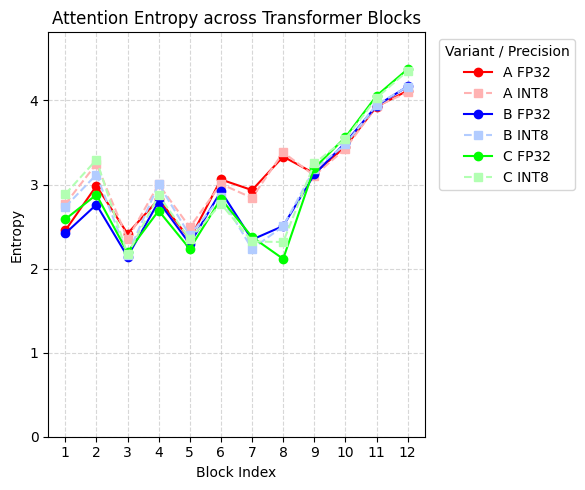

In [31]:
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.quantization import quantize_dynamic
import torch.nn.functional as F

# device setup
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")

# attention entropy computation
def compute_attention_entropy(model, loader, device):
    model.eval().to(device)
    num_layers  = len(model.blocks)
    entropy_sum = torch.zeros(num_layers)
    sample_cnt  = torch.zeros(num_layers)
    eps = 1e-12

    def make_hook(idx):
        def hook(module, inp, out):
            x = inp[0].detach()                    # [B, N, C]
            B, N, C = x.shape
            # QKV projection
            qkv = module.qkv(x)                    # [B, N, 3*C]
            head_dim = C // module.num_heads
            qkv = qkv.view(B, N, 3, module.num_heads, head_dim).permute(2, 0, 3, 1, 4)
            q, k, _ = qkv
            # scaled dot‑product + softmax
            attn = (q @ k.transpose(-2, -1)) * module.scale
            attn = F.softmax(attn, dim=-1)         # [B, heads, N, N]
            cls_attn = attn[:, :, 0, :]            # [B, heads, N]
            ent = -(cls_attn * (cls_attn + eps).log()).sum(-1)
            entropy_sum[idx] += ent.sum().cpu()
            sample_cnt[idx]  += ent.numel()
        return hook

    hooks = [blk.attn.register_forward_hook(make_hook(i)) for i, blk in enumerate(model.blocks)]
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Entropy @ {device}", leave=False):
            imgs = batch["pixel_values"].to(device)
            _ = model(imgs)
    for h in hooks:
        h.remove()

    return (entropy_sum / sample_cnt).numpy()

# variant paths and colors
quant_dir = "quantized_dyn"
variants = {
    "A": {
        "fp32_ckpt": os.path.join(config["output_dir"], "best_val_acc_A.pt"),
        "int8_ckpt": os.path.join(quant_dir,      "vit_ln_dyn_A.pt"),
        "color_fp32": "#FF0000",
        "color_int8": "#FFB2B2"
    },
    "B": {
        "fp32_ckpt": os.path.join(config["output_dir"], "best_val_acc_B.pt"),
        "int8_ckpt": os.path.join(quant_dir,      "vit_ln_dyn_B.pt"),
        "color_fp32": "#0000FF",
        "color_int8": "#B2CCFF"
    },
    "C": {
        "fp32_ckpt": os.path.join(config["output_dir"], "best_val_acc_C.pt"),
        "int8_ckpt": os.path.join(quant_dir,      "vit_ln_dyn_C.pt"),
        "color_fp32": "#00FF00",
        "color_int8": "#B2FFB2"
    },
}

# load, quantize, and compute entropies
results = {}
for var, info in variants.items():
    # FP32 model
    m_fp32 = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"])
    m_fp32.load_state_dict(torch.load(info["fp32_ckpt"], map_location=device_gpu))
    ent_fp32 = compute_attention_entropy(m_fp32, val_loader, device_gpu)
    results[f"{var} FP32"] = (ent_fp32, info["color_fp32"])

    # INT8 model skeleton + load saved weights
    skeleton = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"])
    m_int8 = quantize_dynamic(skeleton, {torch.nn.Linear}, dtype=torch.qint8)
    m_int8.load_state_dict(torch.load(info["int8_ckpt"], map_location="cpu"))
    ent_int8 = compute_attention_entropy(m_int8, val_loader, device_cpu)
    results[f"{var} INT8"] = (ent_int8, info["color_int8"])

# plotting
num_layers = len(next(iter(results.values()))[0])
layers     = np.arange(1, num_layers + 1)
y_max      = max(np.nanmax(vals) for vals, _ in results.values()) * 1.1

plt.figure(figsize=(8, 5))
for label, (vals, color) in results.items():
    marker = "o" if "FP32" in label else "s"
    ls     = "-" if "FP32" in label else "--"
    plt.plot(layers, vals, marker=marker, linestyle=ls, color=color, label=label)

plt.title("Attention Entropy across Transformer Blocks")
plt.xlabel("Block Index")
plt.ylabel("Entropy")
plt.xticks(layers)
plt.ylim(0, y_max)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Variant / Precision", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()


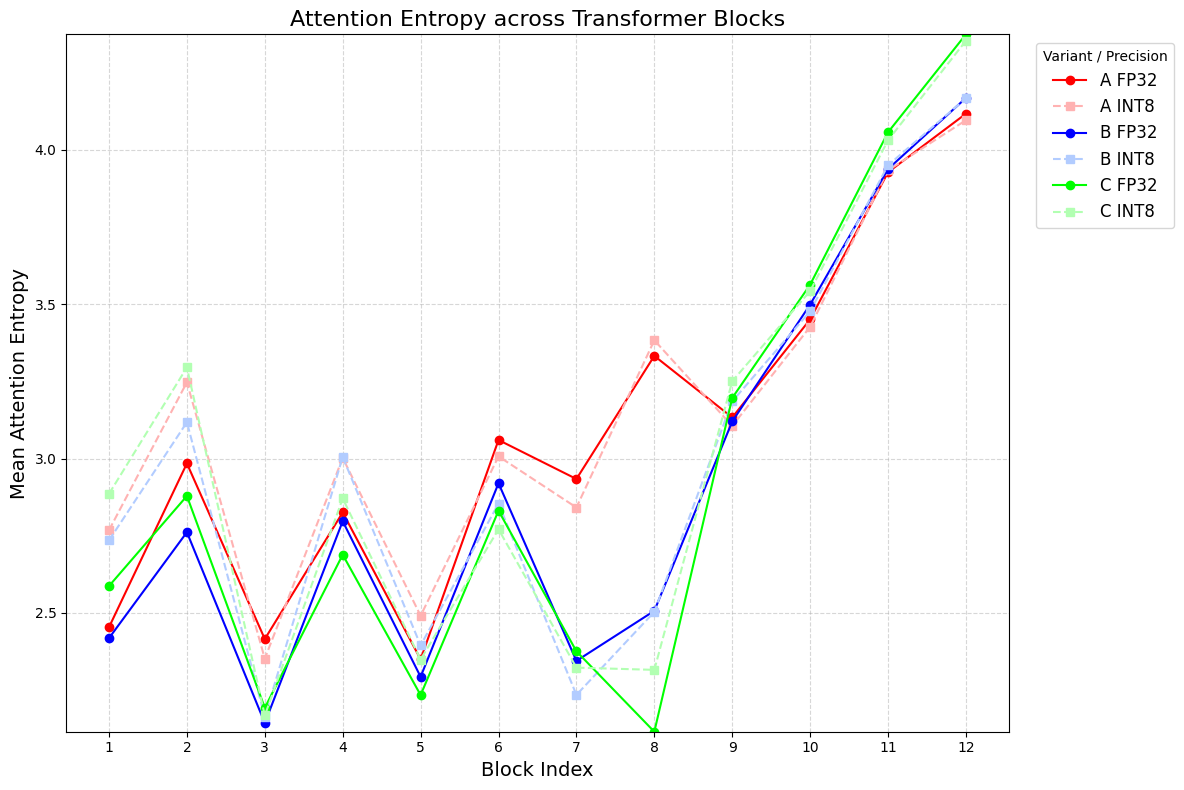

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# compute the min and max across all curves
all_vals = np.concatenate([vals for vals, _ in results.values()])
y_min = np.nanmin(all_vals)
y_max = np.nanmax(all_vals)

# create a larger figure
fig, ax = plt.subplots(figsize=(16, 8))

# Plot each curve
for label, (vals, color) in results.items():
    marker = "o" if "FP32" in label else "s"
    linestyle = "-" if "FP32" in label else "--"
    ax.plot(
        layers,
        vals,
        marker=marker,
        linestyle=linestyle,
        color=color,
        label=label
    )

# axis labels and title
ax.set_title("Attention Entropy across Transformer Blocks", fontsize=16)
ax.set_xlabel("Block Index", fontsize=14)
ax.set_ylabel("Mean Attention Entropy", fontsize=14)
ax.set_xticks(layers)

# zoom to the data's min/max
ax.set_ylim(y_min, y_max)

# grid and legend
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(title="Variant / Precision", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=12)

fig.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

### 4.2 - Saliency-density (focus) Score

In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# Block 1 – helpers for occlusion “focus‑mass” metric (revised)
# ────────────────────────────────────────────────────────────────────────────
import os, gc, torch, timm, numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from captum.attr import Occlusion
from torch.quantization import quantize_dynamic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_vit(num_labels):
    return timm.create_model("vit_base_patch16_224",
                             pretrained=False,
                             num_classes=num_labels)

def load_fp32_and_occlusion(ckpt_path, num_labels):
    """Return (gpu_model, occlusion_attr) for an FP32 checkpoint."""
    m = build_vit(num_labels)
    state = torch.load(ckpt_path, map_location="cpu")
    m.load_state_dict(state)
    m.to(device).eval()
    occ = Occlusion(m)
    return m, occ

def load_int8_and_occlusion(fp32_model, int8_path, num_labels):
    """
    Return (int8_model, occlusion_attr).
    If int8_path exists, load it; otherwise dynamic‑quantize & save.
    """
    if os.path.exists(int8_path):
        q = quantize_dynamic(build_vit(num_labels),
                             {torch.nn.Linear},
                             dtype=torch.qint8)
        state_q = torch.load(int8_path, map_location="cpu")
        q.load_state_dict(state_q)
    else:
        q = quantize_dynamic(fp32_model.cpu(),
                             {torch.nn.Linear},
                             dtype=torch.qint8)
        torch.save(q.state_dict(), int8_path)
    q.to(device).eval()
    occ_q = Occlusion(q)
    return q, occ_q

def focus_mass_occlusion(model, occlusion, loader,
                         pct=0.05, max_imgs=300,
                         patch_size=(16,16), stride=(16,16)):
    """
    Fraction of occlusion‐attribution mass in top `pct` pixels,
    using Captum Occlusion (gradient‐free).
    """
    scores = []
    dev = next(model.parameters()).device
    for i, batch in enumerate(tqdm(loader, desc="Occlusion‑focus", leave=False)):
        if i >= max_imgs:
            break
        inp = batch["pixel_values"].to(dev)  # [1,3,224,224]
        with torch.no_grad():
            pred = model(inp).argmax(dim=-1).item()
        attributions = occlusion.attribute(
            inp,
            target=pred,
            baselines=0,
            sliding_window_shapes=(1, *patch_size),
            strides=(1, *stride),
        )  # → [1,3,224,224]
        # sum over channels → [224,224]
        attr_map = attributions.abs().sum(1).squeeze(0).cpu().numpy()
        flat = attr_map.ravel()
        k    = max(1, int(len(flat) * pct))
        topk = np.partition(flat, -k)[-k:]
        scores.append(topk.sum() / flat.sum())
    return np.mean(scores), np.std(scores)


# ────────────────────────────────────────────────────────────────────────────
# Block 2 – compute & tabulate FP32 & INT8 focus scores
# ────────────────────────────────────────────────────────────────────────────
from tabulate import tabulate

variants = {
  "A": {
    "fp32": os.path.join(config["output_dir"], "best_val_acc_A.pt"),
    "int8": os.path.join("quantized_dyn",          "vit_ln_dyn_A.pt")
  },
  "B": {
    "fp32": os.path.join(config["output_dir"], "best_val_acc_B.pt"),
    "int8": os.path.join("quantized_dyn",          "vit_ln_dyn_B.pt")
  },
  "C": {
    "fp32": os.path.join(config["output_dir"], "best_val_acc_C.pt"),
    "int8": os.path.join("quantized_dyn",          "vit_ln_dyn_C.pt")
  },
}

single_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

rows = []
for name, paths in variants.items():
    # FP32
    m_fp32, occ_fp32 = load_fp32_and_occlusion(paths["fp32"], config["num_labels"])
    mean_fp32, std_fp32 = focus_mass_occlusion(
        m_fp32, occ_fp32, single_loader,
        pct=0.05, max_imgs=300,
        patch_size=(16,16), stride=(16,16)
    )

    # INT8
    m_int8, occ_int8 = load_int8_and_occlusion(m_fp32, paths["int8"], config["num_labels"])
    mean_int8, std_int8 = focus_mass_occlusion(
        m_int8, occ_int8, single_loader,
        pct=0.05, max_imgs=300,
        patch_size=(16,16), stride=(16,16)
    )

    rows.append([
        name,
        f"{mean_fp32:.4f} ± {std_fp32:.4f}",
        f"{mean_int8:.4f} ± {std_int8:.4f}",
        f"{mean_int8 - mean_fp32:+.4f}"
    ])

    # cleanup
    del m_fp32, occ_fp32, m_int8, occ_int8
    torch.cuda.empty_cache()
    gc.collect()

print(tabulate(rows,
               headers=["Variant","FP32 Focus","INT8 Focus","Δ Focus"],
               tablefmt="pretty"))


Occlusion‑focus:   2%|▏         | 94/5000 [06:04<5:18:02,  3.89s/it]

### 4.3 - Robustness Curves